In [39]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
%matplotlib inline

# Explore data

In [40]:
df = pd.read_csv('assets/chipotle_stores.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629 entries, 0 to 2628
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      2629 non-null   object 
 1   location   2629 non-null   object 
 2   address    2629 non-null   object 
 3   latitude   2629 non-null   float64
 4   longitude  2629 non-null   float64
dtypes: float64(2), object(3)
memory usage: 102.8+ KB


In [41]:
states = gpd.read_file('assets/us-states.json')
states.head()

id        name                                           geometry
0  AL     Alabama  POLYGON ((-87.3593 35.00118, -85.60668 34.9847...
1  AK      Alaska  MULTIPOLYGON (((-131.60202 55.11798, -131.5691...
2  AZ     Arizona  POLYGON ((-109.0425 37.00026, -109.04798 31.33...
3  AR    Arkansas  POLYGON ((-94.47384 36.50186, -90.15254 36.496...
4  CA  California  POLYGON ((-123.23326 42.00619, -122.37885 42.0...

### Count Chipotle locations per state and city

In [42]:
df['state'].value_counts()

state
California        421
Texas             226
Ohio              193
Florida           177
New York          160
Illinois          144
Virginia          107
Pennsylvania       96
Maryland           94
Arizona            85
Colorado           79
Minnesota          71
New Jersey         69
North Carolina     65
Massachusetts      62
Georgia            61
Washington         43
Indiana            40
Michigan           39
Missouri           39
Oregon             32
Kansas             30
Nevada             29
Tennessee          26
Connecticut        24
Kentucky           21
South Carolina     21
Washington DC      21
Wisconsin          20
Alabama            15
Oklahoma           12
Utah               11
Nebraska           10
Louisiana          10
Iowa               10
New Mexico          9
Rhode Island        9
Delaware            9
New Hampshire       8
West Virginia       6
Arkansas            6
Maine               5
Idaho               4
Montana             3
Mississippi         2
Verm

In [43]:
df['location'].value_counts().head(50)

location
New York            52
Chicago             36
Houston             31
Columbus            22
Washington DC       21
Los Angeles         20
Las Vegas           19
Dallas              19
Phoenix             19
Cincinnati          17
Austin              16
Orlando             16
Brooklyn            16
San Diego           15
Atlanta             15
Denver              15
San Jose            14
Kansas City         13
Charlotte           13
San Antonio         13
Aurora              13
Philadelphia        13
Baltimore           12
Springfield         12
Sacramento          12
Pittsburgh          11
Scottsdale          10
Miami               10
Tampa               10
Jacksonville        10
Columbia            10
Portland            10
Fort Worth           9
Indianapolis         9
Richmond             9
San Francisco        9
Minneapolis          9
Tucson               9
Lakewood             8
Seattle              8
Glendale             8
Colorado Springs     8
Arlington            8
Na

## Visualize Chipotle Locations

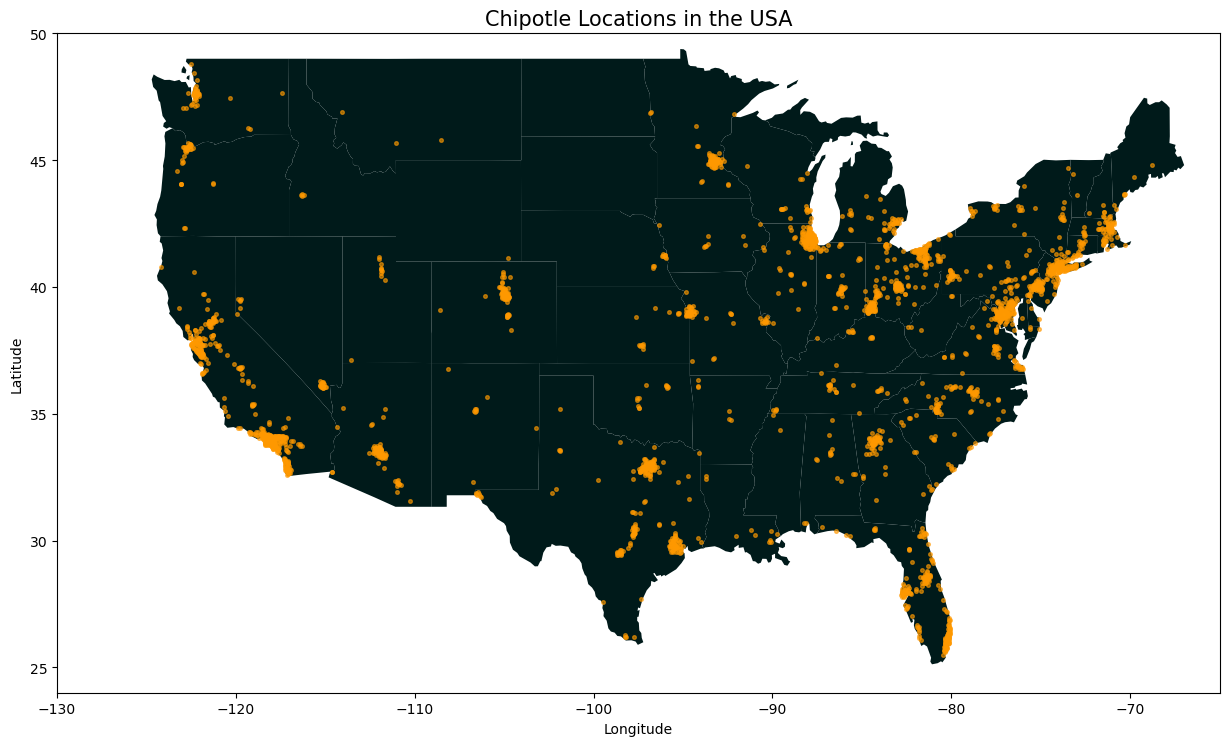

In [44]:
states.plot(figsize=(15,9), facecolor="#001a1a")
plt.scatter(df["longitude"], df["latitude"], s=7, color='#ff9900', alpha=0.6)
plt.title('Chipotle Locations in the USA', fontsize = 15)
plt.xlabel('Longitude',fontsize = 10)
plt.ylabel('Latitude',fontsize = 10)
plt.xlim([-130,-65])
plt.ylim([24,50])
plt.savefig('visualizations/map_all_chipotle_locations.png', dpi=300)
plt.show()

In [45]:
base_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5, tiles="Cartodb Positron")
title_html = '''
            <h3 align="center" style="font-size:16px"><b>{}</b></h3>
            '''.format('Density of Chipotle Locations in the USA')
base_map.get_root().html.add_child(folium.Element(title_html))
base_map.add_child(HeatMap(df[['latitude', 'longitude']]))
base_map.save('visualizations/map_chipotle_locations_heatmap.html')
base_map

***

# Clusters

In [46]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import haversine_distances
import json
import googlemaps
from datetime import datetime
import polyline

In [47]:
df_points=df[['latitude', 'longitude']]
df_points

latitude   longitude
0     32.606813  -85.487328
1     33.509721  -86.802756
2     33.595581  -86.647437
3     33.422582  -86.698279
4     34.154134  -86.841220
...         ...         ...
2624  42.565892  -87.921048
2625  43.067723  -88.048222
2626  46.904247  -96.796618
2627  46.855337  -96.861416
2628  41.160718 -104.805699

[2629 rows x 2 columns]

## K-means Clustering (Centroid-based Clustering)

### Elbow Method

Inertia values:
1 : 781578.6415282853
2 : 197651.65648169338
3 : 111601.9819552638
4 : 102432.48618717713
5 : 73026.43684210481
6 : 68042.45342252255
7 : 39451.71076414571
8 : 26914.246882280353
9 : 23153.252633830572
10 : 19426.07276949429
11 : 16482.163906468286
12 : 13465.907035532367
13 : 11994.901682532982
14 : 9586.945964863513
15 : 8954.537418382075
16 : 8155.622243236605
17 : 7510.443343533518
18 : 6496.53840040493
19 : 6170.936300576511
20 : 5788.240976700441
21 : 5155.940433571943
22 : 5023.432508632692
23 : 4763.9389589811335
24 : 4504.827930385183
25 : 4199.756455630441
26 : 4085.916905934995
27 : 3859.366081521859
28 : 3542.0884329761493
29 : 3416.086833031809


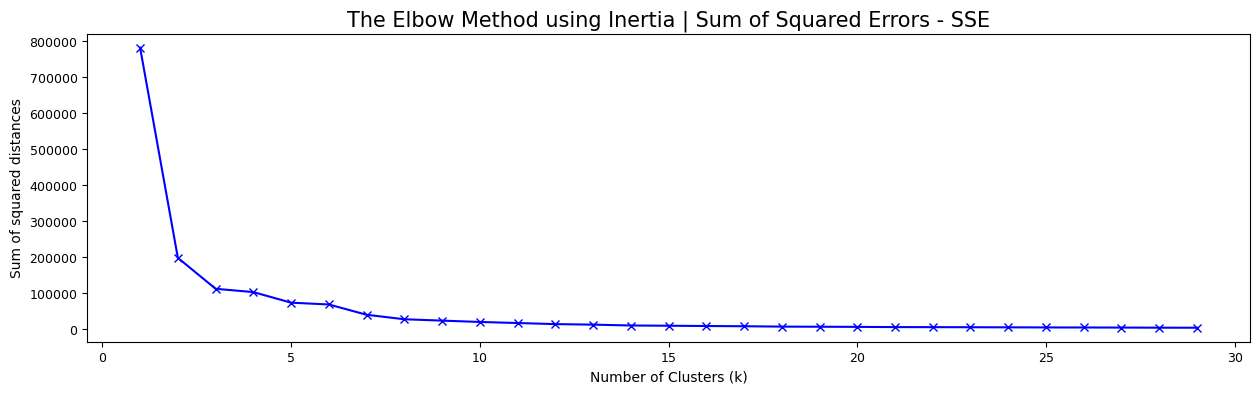

In [48]:
inertias = []
mapping_inertias = {}

K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(df_points)
    
    # Inertias
    inertias.append(kmeanModel.inertia_)
    mapping_inertias[k] = inertias[-1]
    
print("Inertia values:")
for key, val in mapping_inertias.items():
    print(f'{key} : {val}')

plt.figure(figsize=(15,4))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)', fontsize = 10)
plt.ylabel('Sum of squared distances', fontsize = 10)
plt.tick_params(axis='both', labelsize=9)
plt.title('The Elbow Method using Inertia | Sum of Squared Errors - SSE', fontsize = 15)
plt.savefig('visualizations/elbow_method_inertia.png', dpi=300)
plt.show()

* Inertia values drop until around k=7 or k=8, after that the rate of decrease slows down
* At K=7 inertia drops from 68,042 to 39,451 

### Silhouette analysis

For n_clusters = 2, silhouette score = 0.6629272003489965
For n_clusters = 3, silhouette score = 0.5547909262321903
For n_clusters = 4, silhouette score = 0.48909419474994864
For n_clusters = 5, silhouette score = 0.4752924042455981
For n_clusters = 6, silhouette score = 0.4726592021251158
For n_clusters = 7, silhouette score = 0.5583221386708358
For n_clusters = 8, silhouette score = 0.5531367844516408
For n_clusters = 9, silhouette score = 0.5668774831957144
For n_clusters = 10, silhouette score = 0.5789375198767286
For n_clusters = 11, silhouette score = 0.5921569632695232
For n_clusters = 12, silhouette score = 0.5834993167472284
For n_clusters = 13, silhouette score = 0.5878471476758662
For n_clusters = 14, silhouette score = 0.6132604201379457
For n_clusters = 15, silhouette score = 0.6056979352532347
For n_clusters = 16, silhouette score = 0.6042235109623453
For n_clusters = 17, silhouette score = 0.5990333810729167
For n_clusters = 18, silhouette score = 0.616247760636494
For n

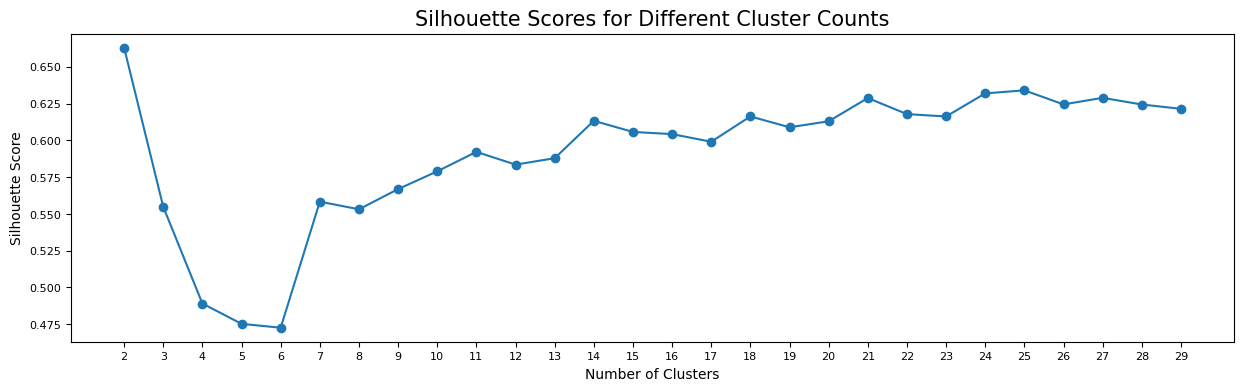

In [49]:
k_range = range(2, 30)
silhouette_scores = {}

# Silhouette scores for all k values
for n_clusters in k_range:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(df_points[["longitude", "latitude"]])

    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(df_points[["longitude", "latitude"]], cluster_labels)
        silhouette_scores[n_clusters] = silhouette_avg
        print(f"For n_clusters = {n_clusters}, silhouette score = {silhouette_avg}")

plt.figure(figsize=(15,4))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker="o")
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters", fontsize = 10)
plt.ylabel("Silhouette Score", fontsize = 10)
plt.tick_params(axis='both', labelsize=8)
plt.title("Silhouette Scores for Different Cluster Counts", fontsize = 15)
plt.savefig('visualizations/silhouette_scores.png', dpi=300)
plt.show()

* Fine-grained clustering (it can be seens as grouping by cities):
    * n_clusters = 25 has a good balance between high silhouette score (0.6339), relatively low inertia (4199.76)
    * n_clusters = 24 is has goos score as well, it has a similar silhouette score (0.6319) and slightly higher inertia (4504.83).
* Coarse-grained (more balance clusters - simplicity with fewer cluster and good scores): 
    * n_clusters = 9  the silhouette score (0.5669) is higher than for n_clusters = 7 and n_clusters = 8, inertia continues to decrease significantly. 
    * n_clusters = 10 higher silhouette score (0.5789) with low inertia rnertia (102432.49). 

### Plot different k values

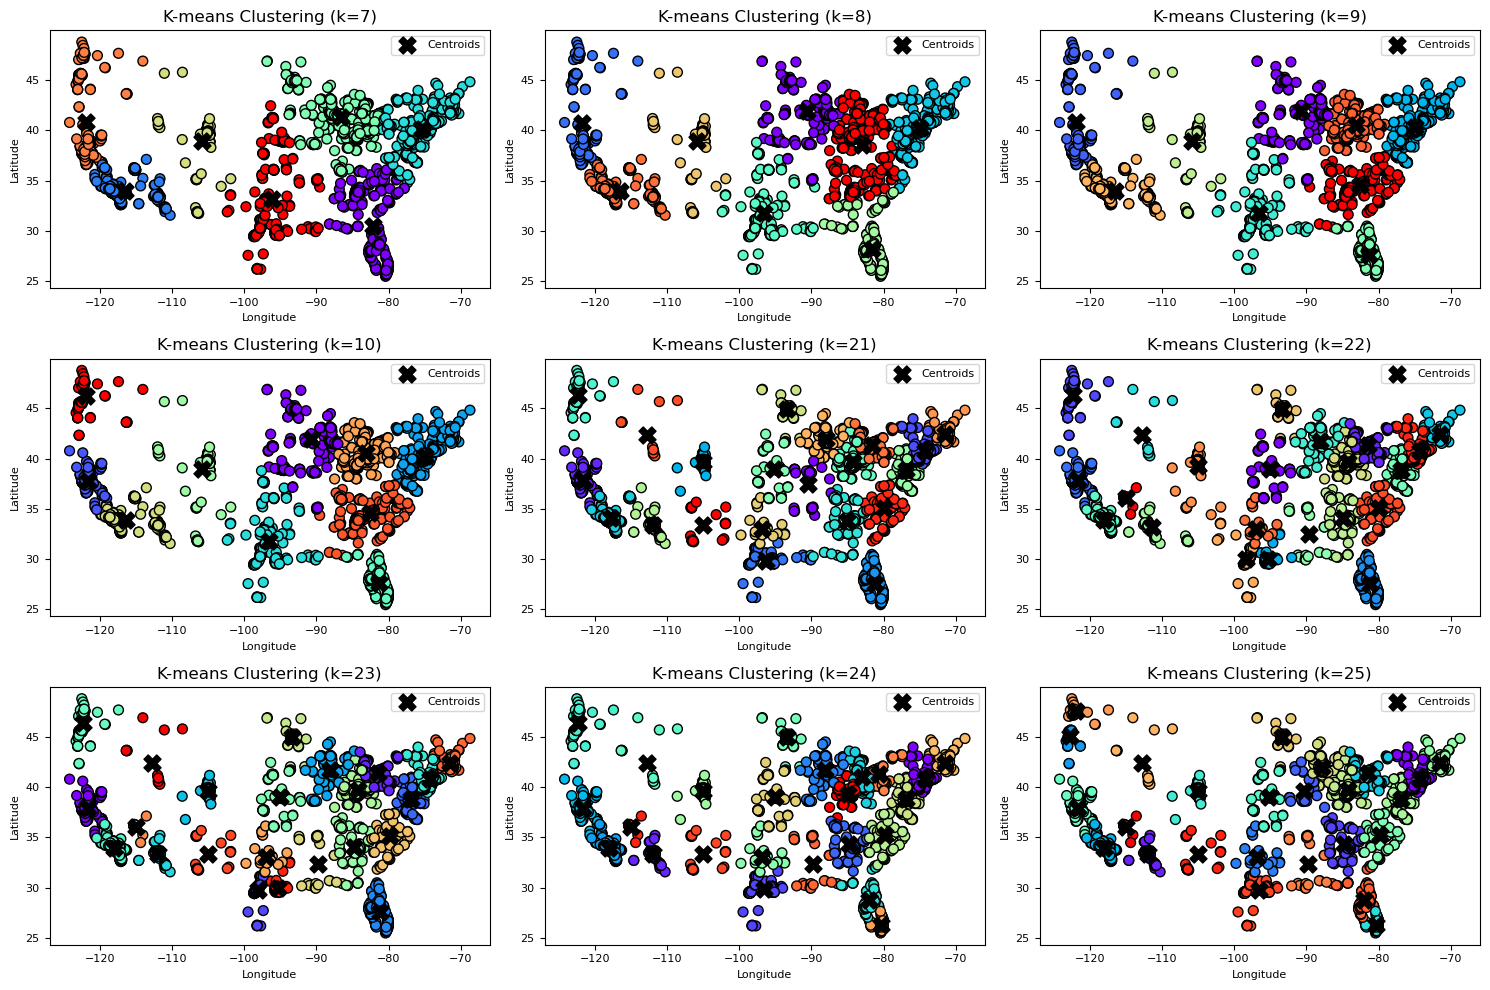

In [50]:
k_range = [7, 8, 9, 10, 21, 22, 23, 24, 25]

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for i, k in enumerate(k_range):
    ax = axes[i // 3, i % 3]

    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    y_kmeans = kmeans.fit_predict(df_points[["longitude", "latitude"]])

    cmap = plt.get_cmap("rainbow", k)

    ax.scatter(df_points["longitude"], df_points["latitude"], c=y_kmeans, cmap=cmap, marker='o', edgecolors='k', s=50)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=150, c='black', label='Centroids', marker='X')

    ax.set_title(f'K-means Clustering (k={k})', fontsize=12)
    ax.set_xlabel('Longitude', fontsize=8)  
    ax.set_ylabel('Latitude', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('visualizations/K_values_comparison.png', dpi=300)
plt.show()


### Clustering (Fine-grained)

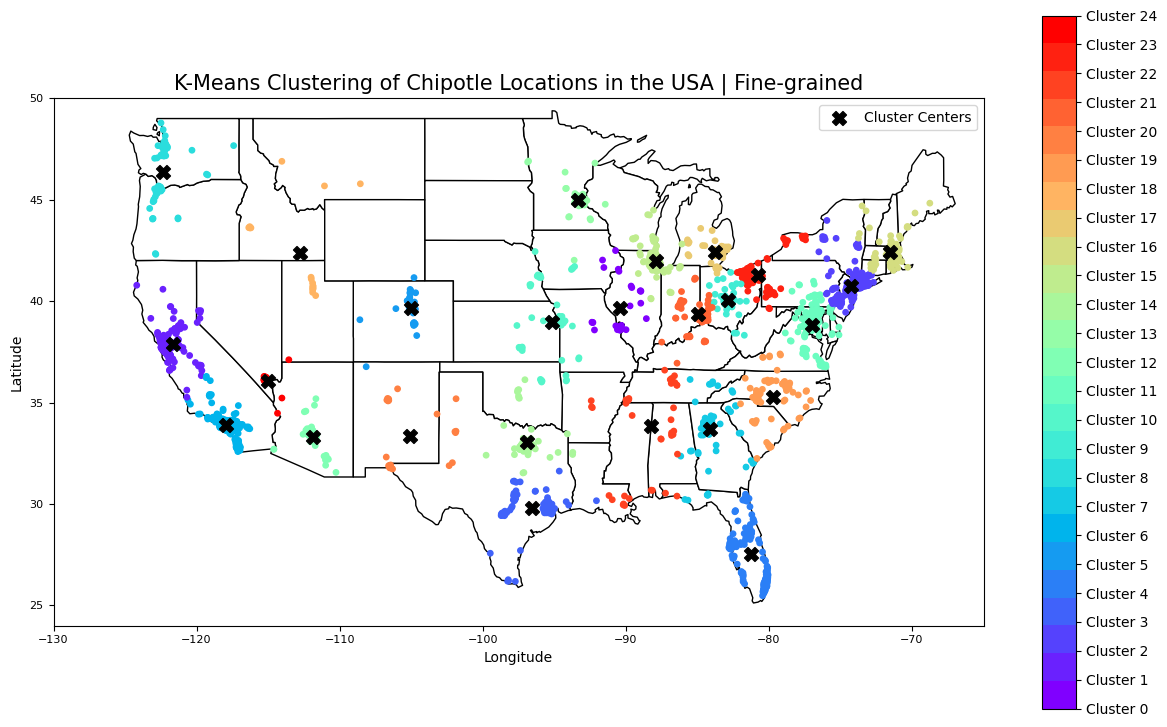

In [51]:
kmeans = KMeans(n_clusters=25, random_state=42,init='k-means++')
kmeans.fit(df_points[["longitude", "latitude"]])
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(15, 9))
states.plot(ax=ax, facecolor="white", edgecolor="black") 

plt.title('K-Means Clustering of Chipotle Locations in the USA | Fine-grained', fontsize = 15)
plt.xlabel('Longitude', fontsize = 10)
plt.ylabel('Latitude', fontsize = 10)
plt.tick_params(axis='both', labelsize=8)
plt.xlim([-130, -65])
plt.ylim([24, 50])

num_clusters = len(np.unique(labels))
cmap = plt.get_cmap("rainbow", num_clusters)

scatter = plt.scatter(df_points['longitude'], df_points['latitude'], c=labels, cmap=cmap, s=15)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_ticks(range(num_clusters))
cbar.set_ticklabels([f"Cluster {i}" for i in range(num_clusters)])

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c="black", marker="X", s=100, label="Cluster Centers")

plt.legend()
plt.savefig('visualizations/clustering_map_kmeans_fine-grained.png', dpi=300)
plt.show()

In [52]:
# Locations per cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()
sorted_clusters = cluster_counts.sort_values(ascending=False)
print(sorted_clusters)

2     277
6     263
11    244
4     169
15    166
1     163
3     116
23    112
14    107
21    100
16    100
19     86
7      85
12     83
5      81
10     77
13     76
8      75
9      65
17     46
22     44
0      29
24     27
20     21
18     17
Name: count, dtype: int64


## Hierarchical Clustering (Agglomerative)

### Dendrogram

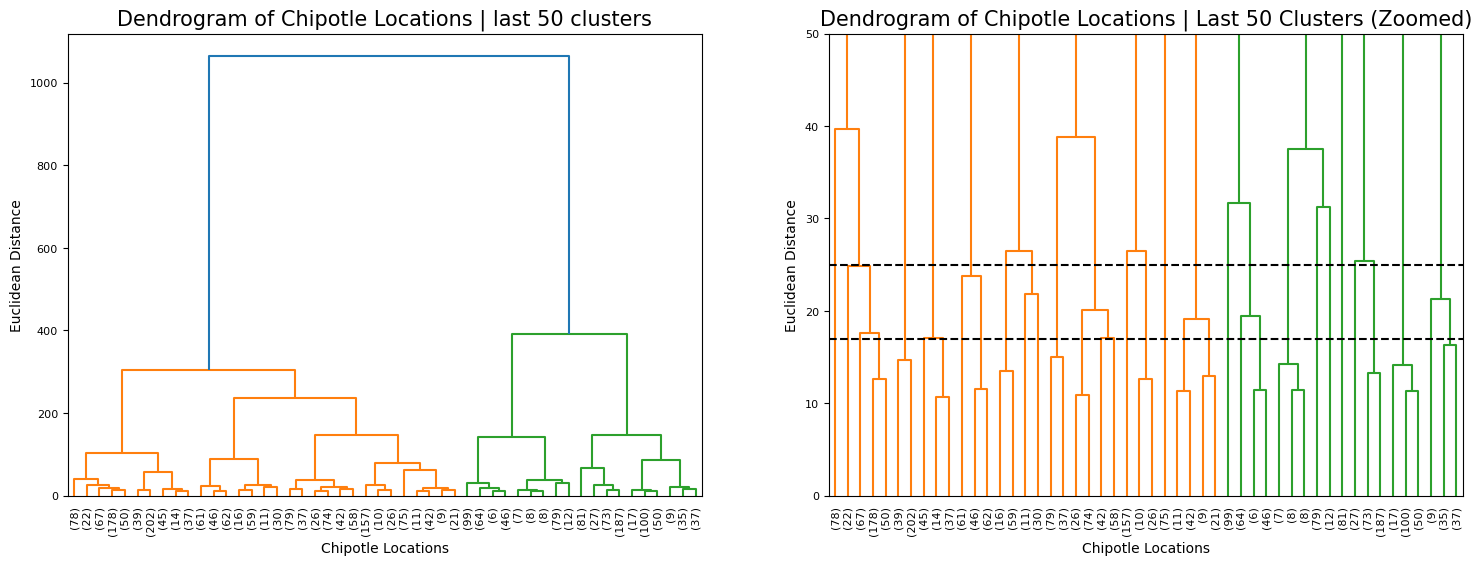

In [53]:
plt.figure(figsize=(18, 6))

# Dendrogram showing the last 50 clusters
plt.subplot(1, 2, 1)
linkage = sch.linkage(df_points, method='ward')
sch.dendrogram(linkage, truncate_mode='lastp', p=50)
plt.title('Dendrogram of Chipotle Locations | last 50 clusters',fontsize = 15)
plt.xlabel('Chipotle Locations',fontsize = 10)
plt.ylabel('Euclidean Distance',fontsize = 10)
plt.tick_params(axis='both', labelsize=8)

# Dendrogram showing the last 50 clusters (zoomed in)
plt.subplot(1, 2, 2)
linkage = sch.linkage(df_points, method='ward')
sch.dendrogram(linkage, truncate_mode='lastp', p=50)
plt.ylim(0, 50)
plt.title('Dendrogram of Chipotle Locations | Last 50 Clusters (Zoomed)',fontsize = 15)
plt.xlabel('Chipotle Locations',fontsize = 10)
plt.ylabel('Euclidean Distance',fontsize = 10)
plt.tick_params(axis='both', labelsize=8)

plt.axhline(y=17, color='black', linestyle='--') 
plt.axhline(y=25, color='black', linestyle='--')  

plt.savefig('visualizations/dendrogram_chipotle_locations.png', dpi=300)
plt.show()

In [54]:
num_clusters = 30
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
labels = agg_clustering.fit_predict(df_points[["longitude", "latitude"]])

# Centers
cluster_centers = np.array([df_points[labels == i][['longitude', 'latitude']].mean() for i in range(num_clusters)])

# Silhouette Score
if n_clusters > 1:
    silhouette_avg = silhouette_score(df_points, labels)
    print(f'Silhouette Score: {silhouette_avg:.4f}')
else:
    print("No Silhouette Score with only one cluster.")
    
# Locations per cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()
sorted_clusters = cluster_counts.sort_values(ascending=False)
print(sorted_clusters)

Silhouette Score: 0.6321
0     295
5     260
2     241
10    167
20    157
7     116
6     108
13    100
3     100
18     99
1      96
26     81
19     79
15     78
21     75
27     75
4      72
28     64
24     61
14     53
17     52
11     36
16     30
9      30
22     27
8      23
23     22
29     12
25     11
12      9
Name: count, dtype: int64


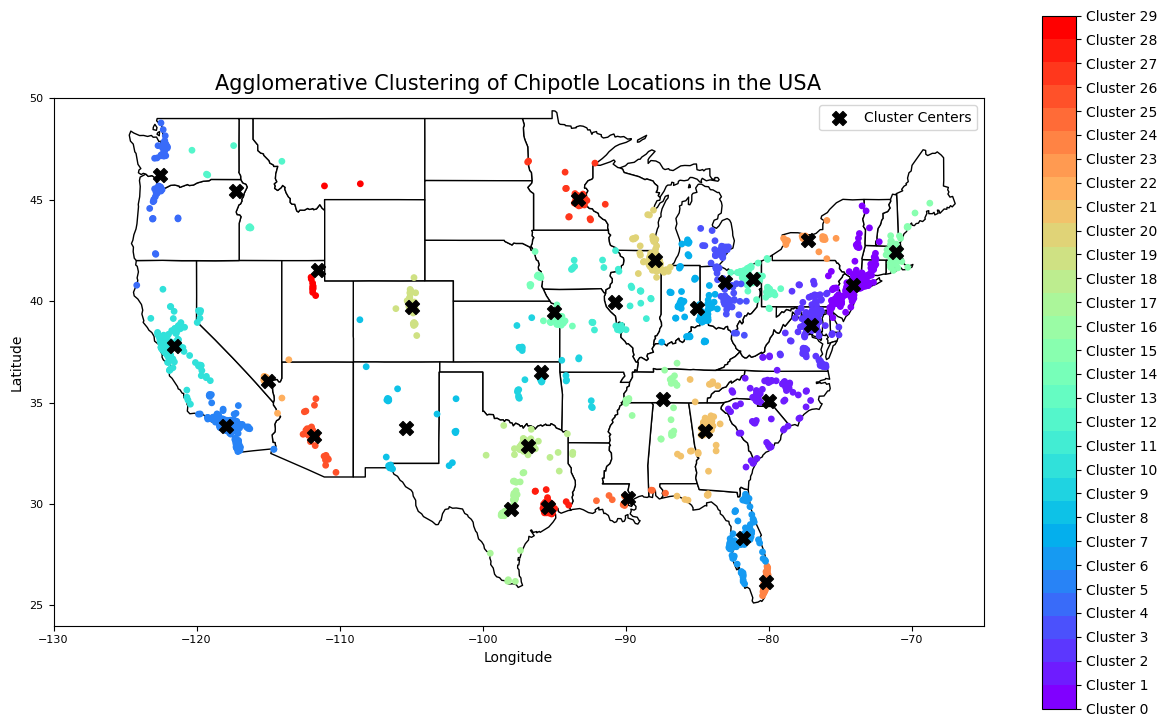

In [55]:
fig, ax = plt.subplots(figsize=(15, 9))
states.plot(ax=ax, facecolor="white", edgecolor="black")

plt.title('Agglomerative Clustering of Chipotle Locations in the USA', fontsize=15)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)
plt.tick_params(axis='both', labelsize=8)
plt.xlim([-130, -65])
plt.ylim([24, 50])

cmap = plt.get_cmap("rainbow", num_clusters)

scatter = plt.scatter(df_points['longitude'], df_points['latitude'], c=labels, cmap=cmap, s=15)
cbar = plt.colorbar(scatter, ax=ax)
tick_labels = [f"Cluster {i}" for i in range(num_clusters)]

cbar.set_ticks(range(num_clusters))
cbar.set_ticklabels(tick_labels)

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c="black", marker="X", s=100, label="Cluster Centers")

plt.legend()
plt.savefig('visualizations/clustering_map_hierarchical.png', dpi=300)
plt.show()

## (Density-based Clustering)

### k-distance plot

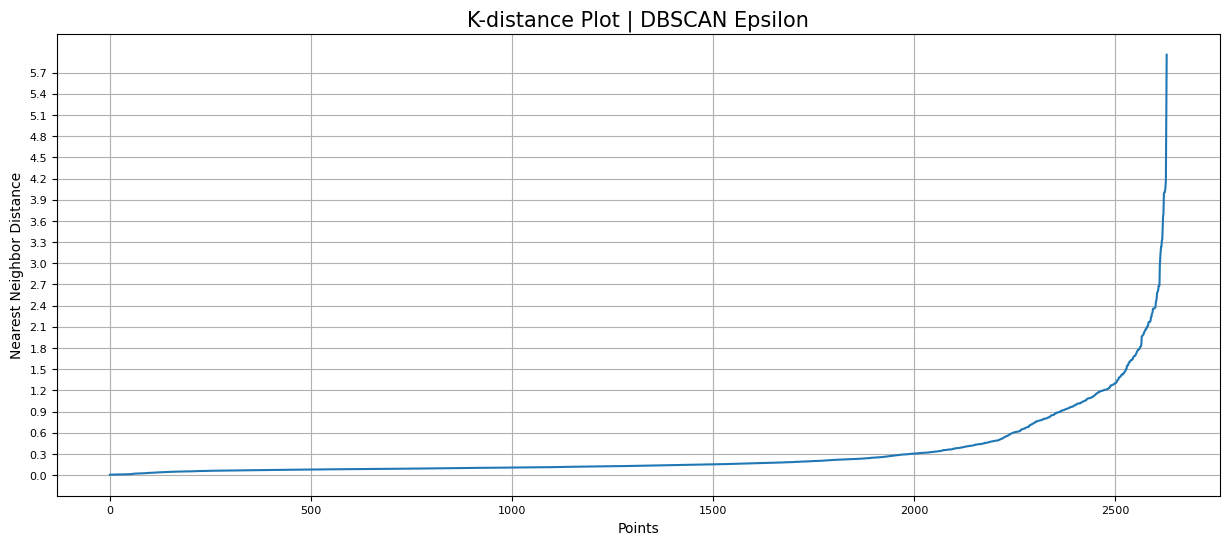

In [56]:
neighbors = NearestNeighbors(n_neighbors=8, metric='euclidean')
neighbors_fit = neighbors.fit(df_points)
distances, indices = neighbors_fit.kneighbors(df_points)

distances = np.sort(distances[:, 6])
plt.figure(figsize=(15, 6))
plt.plot(distances)
plt.xlabel('Points', fontsize = 10)
plt.ylabel('Nearest Neighbor Distance', fontsize = 10)
plt.title('K-distance Plot | DBSCAN Epsilon', fontsize = 15)

plt.yticks(np.arange(0, np.percentile(distances, 100), step=0.3))
plt.tick_params(axis='both', labelsize=8)

plt.grid()
plt.savefig('visualizations/k-distance plot.png', dpi=300)
plt.show()

### DBSCAN Cluster

In [57]:
dbscan = DBSCAN(eps=0.9, min_samples=15, metric='euclidean')
labels = dbscan.fit_predict(df_points[["longitude", "latitude"]])

# Clusters & noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

# Cluster centers
cluster_centers_DBSCAN = []
for cluster in np.unique(labels):
    if cluster != -1:  # Ignore noise
        cluster_points = df_points.iloc[np.where(labels == cluster)[0]]
        center = np.mean(cluster_points, axis=0)
        cluster_centers_DBSCAN.append(center)

cluster_centers = np.array(cluster_centers_DBSCAN)

# Silhouette Score
if n_clusters > 1:
    points_no_noise = df_points[labels != -1]
    labels_no_noise = labels[labels != -1]
    
    if len(np.unique(labels_no_noise)) > 1:
        silhouette_avg = silhouette_score(points_no_noise, labels_no_noise)
        print(f'Silhouette Score (excluding noise): {silhouette_avg:.4f}')
    else:
        print("No silhouette score with only one cluster after removing noise.")
else:
    print("No Silhouette Score with only one cluster.")


Number of clusters: 20
Number of noise points: 329
Silhouette Score (excluding noise): 0.6693


In [58]:
# Locations per cluster (excluding noise -1)
cluster_counts = pd.Series(labels).value_counts().sort_index()
sorted_clusters = cluster_counts.sort_values(ascending=False)
print(sorted_clusters)

 4     601
-1     329
 8     266
 2     258
 5     167
 7     157
 1     143
 16     91
 3      79
 11     70
 0      69
 13     65
 18     63
 6      53
 17     46
 10     42
 19     35
 14     32
 12     24
 9      24
 15     15
Name: count, dtype: int64


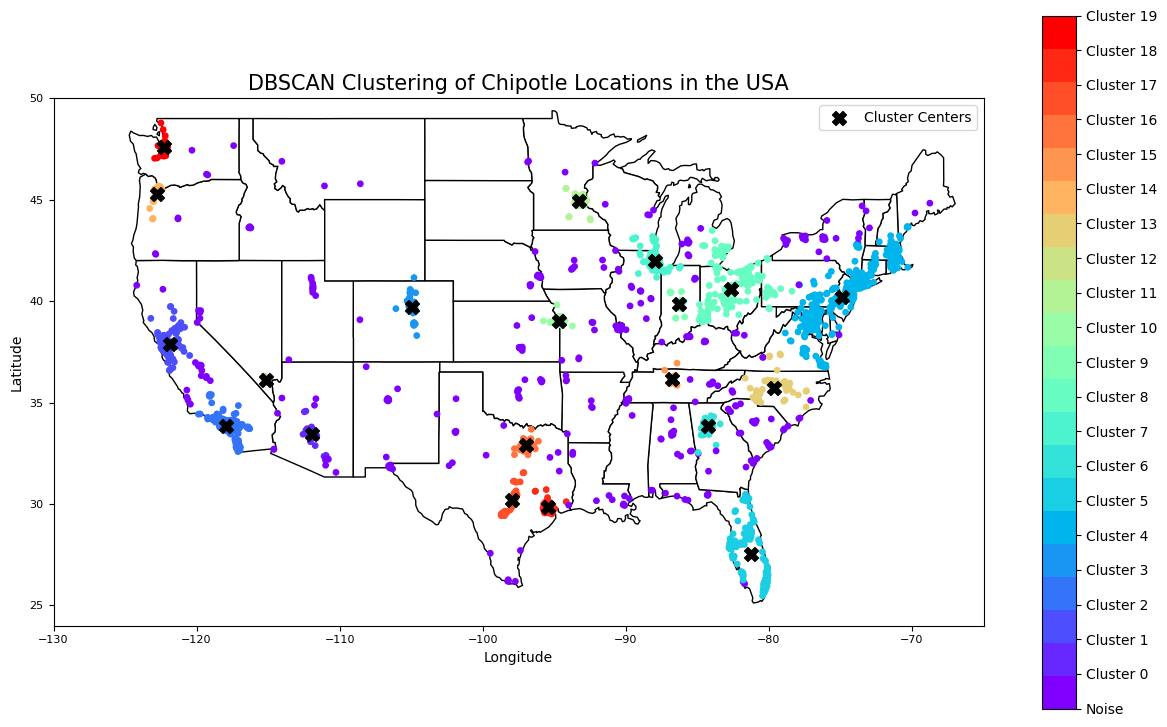

In [59]:
fig, ax = plt.subplots(figsize=(15, 9))
states.plot(ax=ax, facecolor="white", edgecolor="black")

plt.title('DBSCAN Clustering of Chipotle Locations in the USA', fontsize=15)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)
plt.tick_params(axis='both', labelsize=8)
plt.xlim([-130, -65])
plt.ylim([24, 50])

num_clusters = len(np.unique(labels))
cmap = plt.get_cmap("rainbow", num_clusters)

scatter = plt.scatter(df_points['longitude'], df_points['latitude'], c=labels, cmap=cmap, s=15)
cbar = plt.colorbar(scatter, ax=ax)

# Noise points
if -1 in np.unique(labels):
    tick_labels = [f"Noise" if i == -1 else f"Cluster {i}" for i in np.unique(labels)]
else:
    tick_labels = [f"Cluster {i}" for i in range(num_clusters)]

cbar.set_ticks(np.unique(labels))
cbar.set_ticklabels(tick_labels)

plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], c="black", marker="X", s=100, label="Cluster Centers")

plt.legend()
plt.savefig('visualizations/clustering_map_DBSCAN.png', dpi=300)
plt.show()

***

# Choose best living location

For this project, the goal was to find a good place to live near Chipotle locations. Since we don’t need every location to fit perfectly in a cluster, it’s important to pick a model that handles outliers. DBSCAN is great for this because it removes outliers and still gives us meaningful clusters. Plus, it has a solid silhouette score after ignoring the noise.

- Silhouette Score: 0.6693 (excluding noise)
- Number of clusters: 20
- Identified 329 noise points (removed outliers)

In [68]:
# Best cluster with the most Chipotle locations
best_cluster_id = sorted_clusters.index[0]  
if best_cluster_id == -1: 
    best_cluster_id = sorted_clusters.index[1]

best_cluster_size = sorted_clusters[best_cluster_id]
print(f"Best cluster: {best_cluster_id} with {best_cluster_size} Chipotle locations")

Best cluster: 4 with 601 Chipotle locations


In [69]:
# Lat and Long best cluster
best_cluster_points = df_points[labels == best_cluster_id]
best_centroid = np.mean(best_cluster_points[["longitude", "latitude"]], axis=0)
print(f"Best cluster centroid: Longitude {best_centroid.iloc[0]:.4f}, Latitude {best_centroid.iloc[1]:.4f}")

Best cluster centroid: Longitude -74.8941, Latitude 40.1820


## MAP | Best cluster and best living location

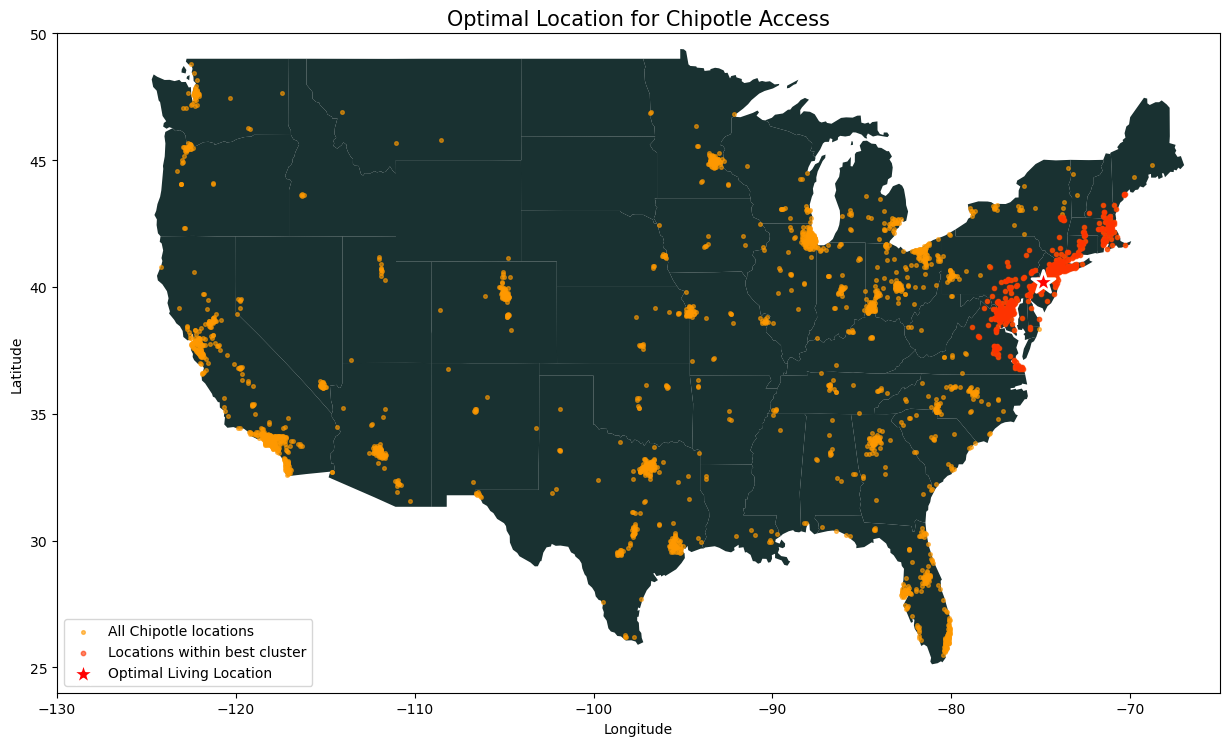

In [62]:
states.plot(figsize=(15,9), facecolor='#001a1a', alpha=0.9)

# All points 
plt.scatter(df["longitude"], df["latitude"], s=7, color='#ff9900', alpha=0.6, label='All Chipotle locations')

# Best cluster points 
plt.scatter(best_cluster_points["longitude"], best_cluster_points["latitude"], s=10, color='#ff3300', alpha=0.6, label='Locations within best cluster')

# Optimal location 
plt.scatter(best_centroid.iloc[0], best_centroid.iloc[1], s=300, color='#ff0000', marker='*', edgecolors= "white", linewidth=2, label='Optimal Living Location')

plt.title('Optimal Location for Chipotle Access', fontsize = 15)
plt.xlabel('Longitude',fontsize = 10)
plt.ylabel('Latitude',fontsize = 10)
plt.xlim([-130,-65])
plt.ylim([24,50])
plt.savefig('visualizations/map_best_living_location.png', dpi=300)
plt.legend(loc='lower left')
plt.show()

## Distance and driving time between the two farthest points

In [63]:
# Distance between the two farthest points in best cluster (haversine for spherical Earth)
points = best_cluster_points[["latitude", "longitude"]].values
radians = np.radians(points) 

# All pairwise distances  
distances = haversine_distances(radians) * 6371  # Earth's radius = 6371 km

# Maximum distance
x, y = np.unravel_index(distances.argmax(), distances.shape)

# Coordinates
point1 = points[x]
point2 = points[y]

max_distance = distances[x, y]

print(f"Maximum distance within the best cluster: {max_distance:.2f} km")
print(f"First point: Latitude {point1[0]:.4f}, Longitude {point1[1]:.4f}")
print(f"Second point: Latitude {point2[0]:.4f}, Longitude {point2[1]:.4f}")

Maximum distance within the best cluster: 932.26 km
First point: Latitude 43.6606, Longitude -70.2667
Second point: Latitude 37.4155, Longitude -77.6412


In [70]:
# API key
key_file_path = "API_key.json"
with open(key_file_path, "r") as file:
    key = json.load(file)
API_KEY = key.get("API_KEY")

gmaps = googlemaps.Client(key=API_KEY)

# Coordinates
point1 = (point1[0], point1[1])
point2 = (point2[0], point2[1])

# Driving directions
directions = gmaps.directions(point1, point2, mode="driving", departure_time=datetime.now())
route_pol = directions[0]['overview_polyline']['points'] # decoded polyline
route = polyline.decode(route_pol) # lat-long points

# Estimated duration
duration = directions[0]['legs'][0]['duration']['text']
print(f"Estimated driving time: {duration}")

# Map
map_center = [best_cluster_points["latitude"].mean(), best_cluster_points["longitude"].mean()]
map = folium.Map(location=map_center, zoom_start=6.5, tiles="Cartodb Positron")
title_html = '''
            <h3 align="center" style="font-size:16px"><b>{}</b></h3>
            '''.format('Optimal Location and driving route for Chipotle Access')
map.get_root().html.add_child(folium.Element(title_html))

# Two points
folium.Marker(point1, popup=f"Point 1: {point1}").add_to(map)
folium.Marker(point2, popup=f"Point 2: {point2}").add_to(map)

# All points 
for _, row in df.iterrows():
    folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius=3, color='#ff9900', fill=True, fill_color='#ff9900', fill_opacity=0.6, popup='Chipotle Location').add_to(map)
    
# Best cluster points
for _, row in best_cluster_points.iterrows():
    folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius=4, color='#ff3300', fill=True, fill_color='#ff3300', fill_opacity=0.7, popup='Locations within best cluster').add_to(map)

# Optimal location 
folium.Marker(location=[best_centroid.iloc[1], best_centroid.iloc[0]], icon=folium.Icon(color='red', icon='star', prefix='fa'), popup='Optimal Living Location').add_to(map)

# Driving Route
folium.PolyLine(locations=route, color="blue", weight=3, opacity=1).add_to(map)

map.save("visualizations/map_driving_route.html")
map


Estimated driving time: 10 hours 15 mins
